# GEM Data Hackathon: Entrepreneur Profile Analysis

This notebook implements Section 1 of our analysis plan: Entrepreneur Backgrounds & Demographic Analysis.

## Objectives
- Create comprehensive entrepreneur personas based on demographic patterns
- Analyze intersectionality of demographic factors (gender, race, age, education, income)
- Compare profiles between new and established entrepreneurs
- Identify key background factors that predict entrepreneurial activity

## Setup and Data Loading

In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score

# Set plot styling
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

In [4]:
# Load the GEM data
gem_data = pd.read_csv('../data/Hackathon_GEM_Data_FULL.csv')

# Display basic information about the dataset
print(f"Dataset shape: {gem_data.shape}")
gem_data.head()

Dataset shape: (15868, 36)


,weight,new_entrepreneur,established_entrepreneur,knows_entrepreneur,local_opportunity,entrepreneurial_skill,fear_of_failure,wants_entrepreneurship,respects_entrepreneurship,follows_entrepreneurship,...,new_entrepreneur_owners,new_entrepreneur_external_sales,established_entrepreneur_external_sales,new_entrepreneur_innovation,year,new_entrepreneur_local_innovation,new_entrepreneur_employees,established_entrepreneur_employees,race,region
0,0.674020,No,No,No,No,No,No,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2015,NaN,NaN,NaN,White,Great Lakes
1,0.674020,No,No,No,NaN,No,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2015,NaN,NaN,NaN,White,Great Lakes
2,0.814409,No,Yes,No,No,Yes,Yes,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2015,NaN,NaN,1.0,White,Great Lakes
3,1.289586,No,No,No,NaN,Yes,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2015,NaN,NaN,NaN,Black,Great Lakes
4,0.963587,No,No,No,NaN,No,No,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,2015,NaN,NaN,NaN,Black,Southeast


## Data Overview and Cleaning

Let's examine the variables in our dataset and prepare it for analysis.

In [5]:
# Check variable names to understand what data we have
print("Columns in the dataset:")
print(gem_data.columns.tolist())

Columns in the dataset:
['weight', 'new_entrepreneur', 'established_entrepreneur', 'knows_entrepreneur', 'local_opportunity', 'entrepreneurial_skill', 'fear_of_failure', 'wants_entrepreneurship', 'respects_entrepreneurship', 'follows_entrepreneurship', 'future_startup', 'discontinued_business', 'discontinued_business_continuation', 'is_investor', 'investment', 'investment_relationship', 'gender', 'age_range', 'household_size', 'household_income', 'education', 'new_entrepreneur_industry', 'established_entrepreneur_industry', 'new_entrepreneur_new_jobs', 'established_entrepreneur_new_jobs', 'established_entrepreneur_owners', 'new_entrepreneur_owners', 'new_entrepreneur_external_sales', 'established_entrepreneur_external_sales', 'new_entrepreneur_innovation', 'year', 'new_entrepreneur_local_innovation', 'new_entrepreneur_employees', 'established_entrepreneur_employees', 'race', 'region']


In [6]:
# Check data types and missing values
gem_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15868 entries, 0 to 15867
Data columns (total 36 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   weight                                   15868 non-null  float64
 1   new_entrepreneur                         15868 non-null  object 
 2   established_entrepreneur                 15868 non-null  object 
 3   knows_entrepreneur                       15761 non-null  object 
 4   local_opportunity                        13316 non-null  object 
 5   entrepreneurial_skill                    14795 non-null  object 
 6   fear_of_failure                          15120 non-null  object 
 7   wants_entrepreneurship                   12070 non-null  object 
 8   respects_entrepreneurship                12082 non-null  object 
 9   follows_entrepreneurship                 12417 non-null  object 
 10  future_startup                           15420

In [7]:
# Handle missing values (for key demographic variables)
demographic_vars = ['gender', 'age_range', 'race', 'education', 'household_income', 'region', 'household_size']
entrepreneurship_vars = ['new_entrepreneur', 'established_entrepreneur']

# Check missing values in key variables
missing_data = pd.DataFrame({
    'Missing Values': gem_data[demographic_vars + entrepreneurship_vars].isnull().sum(),
    'Percentage': 100 * gem_data[demographic_vars + entrepreneurship_vars].isnull().sum() / len(gem_data)
})

missing_data.sort_values('Percentage', ascending=False)

,Missing Values,Percentage
household_income,13515,85.171414
education,13211,83.255609
race,3238,20.405848
household_size,305,1.922107
gender,0,0.000000
age_range,0,0.000000
region,0,0.000000
new_entrepreneur,0,0.000000
established_entrepreneur,0,0.000000


In [8]:
# Create a clean dataset for analysis with only complete cases for key variables
analysis_data = gem_data.dropna(subset=demographic_vars + entrepreneurship_vars)
print(f"Complete cases: {len(analysis_data)} out of {len(gem_data)} ({100*len(analysis_data)/len(gem_data):.1f}%)")

Complete cases: 2301 out of 15868 (14.5%)


## 1. Weighted Demographic Analysis of Entrepreneurs

Let's examine the demographic distributions of entrepreneurs, applying proper survey weights.

In [9]:
# Function to calculate weighted percentage of entrepreneurs by a demographic variable
def weighted_entrepreneur_percentage(data, group_var):
    # For new entrepreneurs
    new_ent_by_group = pd.crosstab(
        index=data[group_var],
        columns=data['new_entrepreneur'],
        values=data['weight'],
        aggfunc='sum',
        normalize='index'
    ) * 100
    
    # For established entrepreneurs
    estab_ent_by_group = pd.crosstab(
        index=data[group_var],
        columns=data['established_entrepreneur'],
        values=data['weight'],
        aggfunc='sum',
        normalize='index'
    ) * 100
    
    # Combine into one dataframe
    if 'Yes' in new_ent_by_group.columns and 'Yes' in estab_ent_by_group.columns:
        result = pd.DataFrame({
            'New Entrepreneur (%)': new_ent_by_group['Yes'],
            'Established Entrepreneur (%)': estab_ent_by_group['Yes']
        })
        
        # Calculate the weighted counts for each group (for reference)
        group_counts = data.groupby(group_var)['weight'].sum()
        result['Weighted Count'] = group_counts
        result['Weighted Percentage'] = 100 * group_counts / group_counts.sum()
        
        return result
    else:
        print("Error: 'Yes' category not found in one of the entrepreneur variables.")
        return None

In [10]:
# Gender analysis
gender_entrepreneurship = weighted_entrepreneur_percentage(analysis_data, 'gender')
gender_entrepreneurship

,New Entrepreneur (%),Established Entrepreneur (%),Weighted Count,Weighted Percentage
gender,,,,
female,9.364545,5.798239,1135.370153,49.284336
male,15.226388,9.270348,1168.343867,50.715664


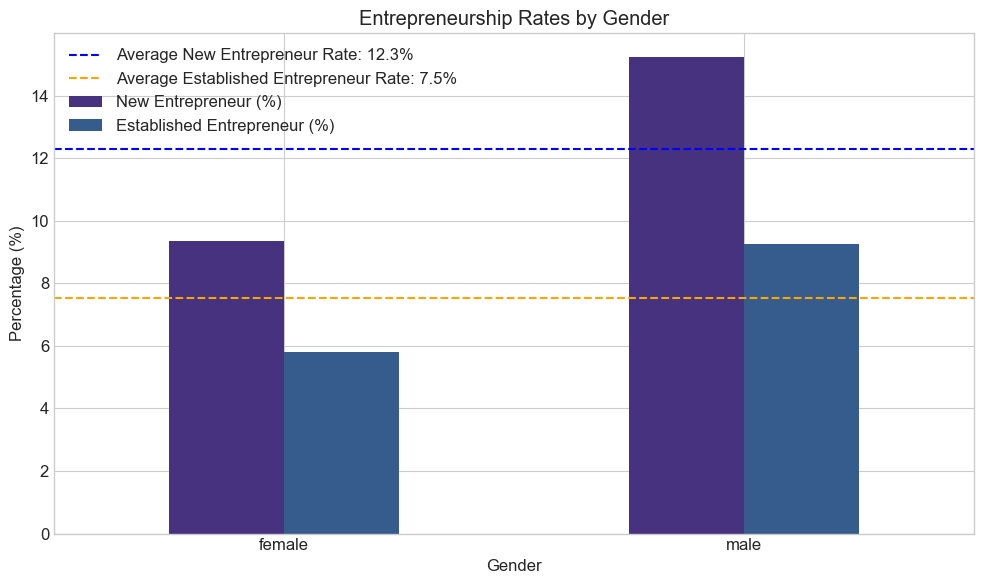

In [11]:
# Visualize gender differences in entrepreneurship
gender_entrepreneurship[['New Entrepreneur (%)', 'Established Entrepreneur (%)']].plot(kind='bar', figsize=(10, 6))
plt.title('Entrepreneurship Rates by Gender')
plt.ylabel('Percentage (%)')
plt.xlabel('Gender')
plt.xticks(rotation=0)
plt.axhline(y=gender_entrepreneurship['New Entrepreneur (%)'].mean(), color='blue', linestyle='--', 
           label=f"Average New Entrepreneur Rate: {gender_entrepreneurship['New Entrepreneur (%)'].mean():.1f}%")
plt.axhline(y=gender_entrepreneurship['Established Entrepreneur (%)'].mean(), color='orange', linestyle='--',
           label=f"Average Established Entrepreneur Rate: {gender_entrepreneurship['Established Entrepreneur (%)'].mean():.1f}%")
plt.legend()
plt.tight_layout()
plt.show()

In [12]:
# Age analysis
age_entrepreneurship = weighted_entrepreneur_percentage(analysis_data, 'age_range')
age_entrepreneurship

,New Entrepreneur (%),Established Entrepreneur (%),Weighted Count,Weighted Percentage
age_range,,,,
18-24,10.935915,1.296053,351.198465,15.244881
25-34,14.071113,5.229900,505.271344,21.932902
35-44,16.845324,7.329604,495.952044,21.528369
45-54,11.438298,12.556749,519.428020,22.547418
55-64,7.353308,9.630232,431.864146,18.746430


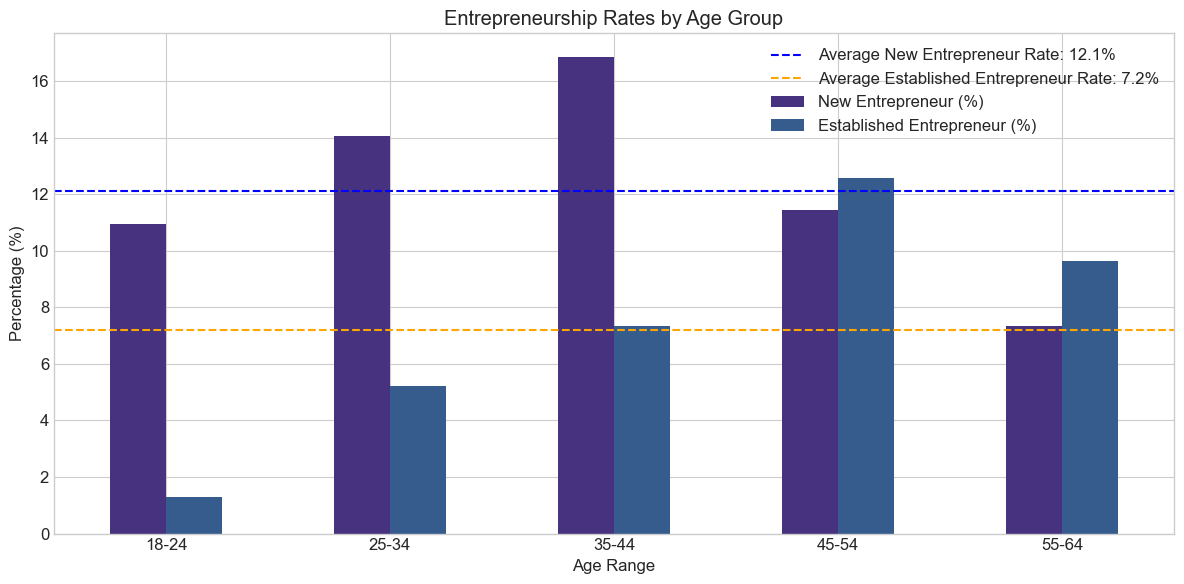

In [13]:
# Visualize age differences in entrepreneurship
age_entrepreneurship[['New Entrepreneur (%)', 'Established Entrepreneur (%)']].plot(kind='bar', figsize=(12, 6))
plt.title('Entrepreneurship Rates by Age Group')
plt.ylabel('Percentage (%)')
plt.xlabel('Age Range')
plt.xticks(rotation=0)
plt.axhline(y=age_entrepreneurship['New Entrepreneur (%)'].mean(), color='blue', linestyle='--', 
           label=f"Average New Entrepreneur Rate: {age_entrepreneurship['New Entrepreneur (%)'].mean():.1f}%")
plt.axhline(y=age_entrepreneurship['Established Entrepreneur (%)'].mean(), color='orange', linestyle='--',
           label=f"Average Established Entrepreneur Rate: {age_entrepreneurship['Established Entrepreneur (%)'].mean():.1f}%")
plt.legend()
plt.tight_layout()
plt.show()

In [14]:
# Race analysis
race_entrepreneurship = weighted_entrepreneur_percentage(analysis_data, 'race')
race_entrepreneurship

,New Entrepreneur (%),Established Entrepreneur (%),Weighted Count,Weighted Percentage
race,,,,
Black,15.117097,4.776663,282.889780,12.279726
Hispanic,9.883897,3.514419,280.957137,12.195834
Other,14.725599,6.442523,204.021388,8.856194
White,11.957009,8.959897,1535.845713,66.668245


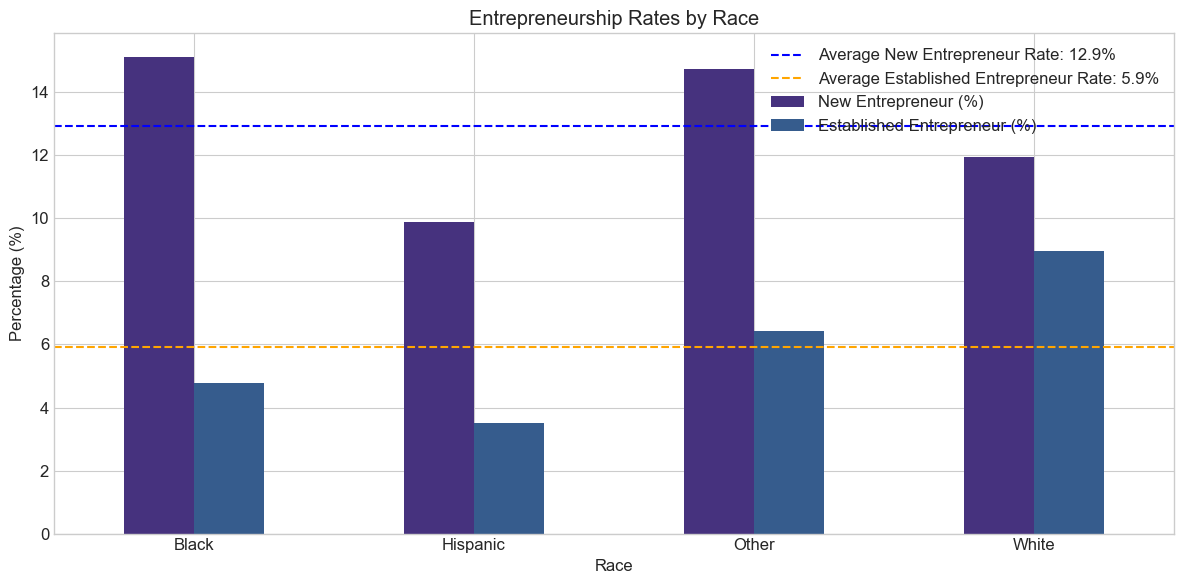

In [15]:
# Visualize race differences in entrepreneurship
race_entrepreneurship[['New Entrepreneur (%)', 'Established Entrepreneur (%)']].plot(kind='bar', figsize=(12, 6))
plt.title('Entrepreneurship Rates by Race')
plt.ylabel('Percentage (%)')
plt.xlabel('Race')
plt.xticks(rotation=0)
plt.axhline(y=race_entrepreneurship['New Entrepreneur (%)'].mean(), color='blue', linestyle='--', 
           label=f"Average New Entrepreneur Rate: {race_entrepreneurship['New Entrepreneur (%)'].mean():.1f}%")
plt.axhline(y=race_entrepreneurship['Established Entrepreneur (%)'].mean(), color='orange', linestyle='--',
           label=f"Average Established Entrepreneur Rate: {race_entrepreneurship['Established Entrepreneur (%)'].mean():.1f}%")
plt.legend()
plt.tight_layout()
plt.show()

In [16]:
# Education analysis
education_entrepreneurship = weighted_entrepreneur_percentage(analysis_data, 'education')
education_entrepreneurship

,New Entrepreneur (%),Established Entrepreneur (%),Weighted Count,Weighted Percentage
education,,,,
Completed College/University,14.057311,7.629274,752.476262,32.663614
Completed High School,9.815412,4.768335,529.816258,22.998352
Degree Graduate (Master's or PhD),13.092045,12.599252,397.802996,17.267898
None/Less than High School,9.128924,14.142895,34.576622,1.500908
Some College/University,13.528436,5.480159,498.406740,21.634922
Some High School,4.163492,10.090249,90.635141,3.934305


<Figure size 1400x700 with 0 Axes>

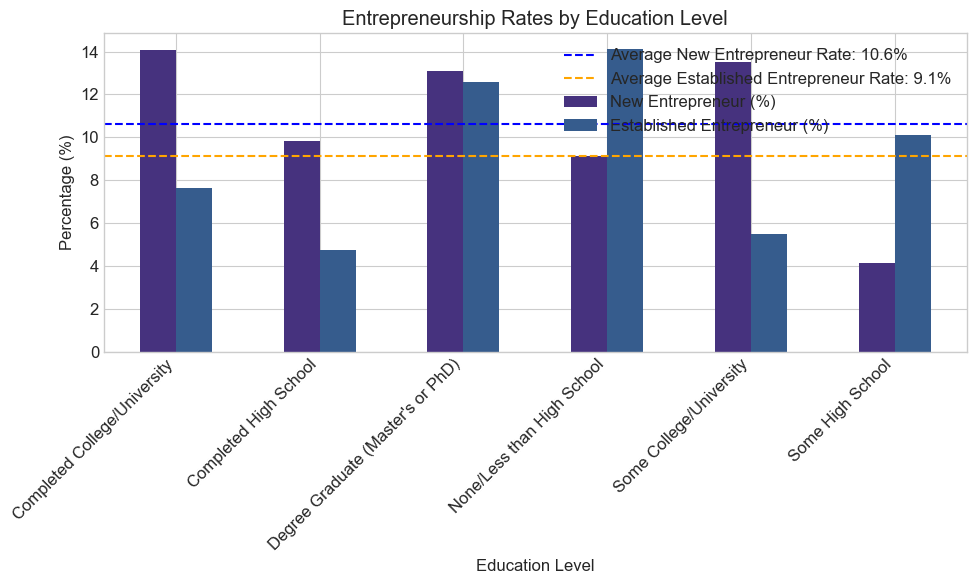

In [17]:
# Visualize education differences in entrepreneurship
plt.figure(figsize=(14, 7))
education_entrepreneurship[['New Entrepreneur (%)', 'Established Entrepreneur (%)']].plot(kind='bar')
plt.title('Entrepreneurship Rates by Education Level')
plt.ylabel('Percentage (%)')
plt.xlabel('Education Level')
plt.xticks(rotation=45, ha='right')
plt.axhline(y=education_entrepreneurship['New Entrepreneur (%)'].mean(), color='blue', linestyle='--', 
           label=f"Average New Entrepreneur Rate: {education_entrepreneurship['New Entrepreneur (%)'].mean():.1f}%")
plt.axhline(y=education_entrepreneurship['Established Entrepreneur (%)'].mean(), color='orange', linestyle='--',
           label=f"Average Established Entrepreneur Rate: {education_entrepreneurship['Established Entrepreneur (%)'].mean():.1f}%")
plt.legend()
plt.tight_layout()
plt.show()

In [18]:
# Region analysis
region_entrepreneurship = weighted_entrepreneur_percentage(analysis_data, 'region')
region_entrepreneurship

,New Entrepreneur (%),Established Entrepreneur (%),Weighted Count,Weighted Percentage
region,,,,
Central Midwest,9.748305,10.991844,98.594956,4.279826
Great Lakes,10.594729,7.803526,389.085831,16.889502
Mid-Atlantic,12.378501,7.070337,232.186178,10.078776
Mountain and Plains,20.793377,10.017369,75.993940,3.298758
New England,12.387873,7.268321,108.638594,4.715802
New York-New Jersey,8.256840,5.076021,207.469348,9.005864
Pacific Northwest,10.066417,10.099451,100.861568,4.378216
Pacific Southwest,12.813688,6.213280,350.695009,15.223027
South,12.789986,6.300214,282.556568,12.265262


<Figure size 1400x700 with 0 Axes>

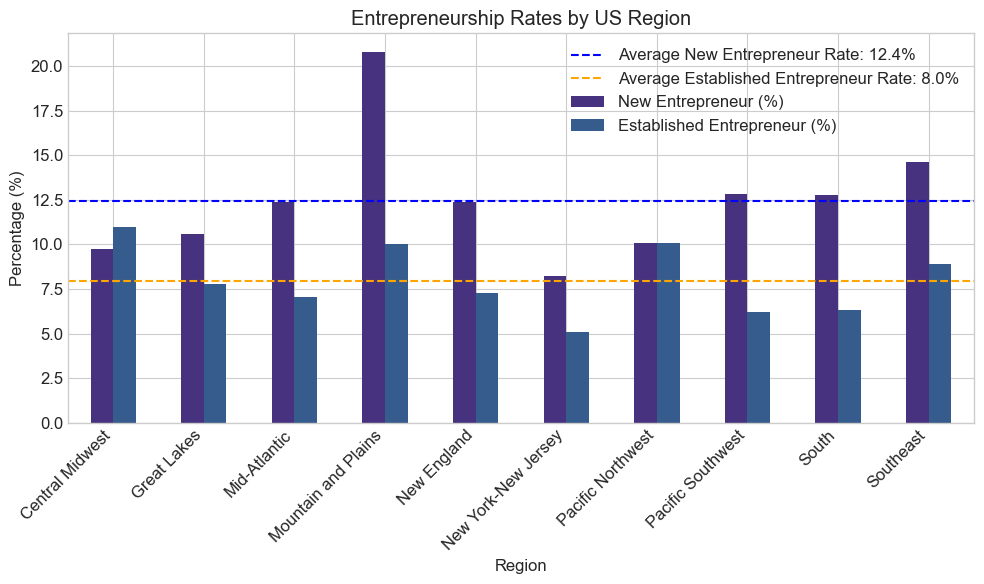

In [19]:
# Visualize regional differences in entrepreneurship
plt.figure(figsize=(14, 7))
region_entrepreneurship[['New Entrepreneur (%)', 'Established Entrepreneur (%)']].plot(kind='bar')
plt.title('Entrepreneurship Rates by US Region')
plt.ylabel('Percentage (%)')
plt.xlabel('Region')
plt.xticks(rotation=45, ha='right')
plt.axhline(y=region_entrepreneurship['New Entrepreneur (%)'].mean(), color='blue', linestyle='--', 
           label=f"Average New Entrepreneur Rate: {region_entrepreneurship['New Entrepreneur (%)'].mean():.1f}%")
plt.axhline(y=region_entrepreneurship['Established Entrepreneur (%)'].mean(), color='orange', linestyle='--',
           label=f"Average Established Entrepreneur Rate: {region_entrepreneurship['Established Entrepreneur (%)'].mean():.1f}%")
plt.legend()
plt.tight_layout()
plt.show()

In [20]:
# Household income analysis
income_entrepreneurship = weighted_entrepreneur_percentage(analysis_data, 'household_income')
income_entrepreneurship

,New Entrepreneur (%),Established Entrepreneur (%),Weighted Count,Weighted Percentage
household_income,,,,
"$100,000 to under $150,000",16.201026,11.368392,337.150300,14.635076
"$15,000 to under $25,000",6.301544,4.315819,218.628096,9.490245
"$150,000 to under $200,000",15.746233,12.638412,144.881583,6.289044
"$25,000 to under $35,000",11.283838,3.642726,186.961599,8.115660
"$35,000 to under $50,000",11.558748,4.394955,317.908512,13.799825
"$50,000 to under $75,000",12.725577,6.205604,385.236224,16.722398
"$75,000 to under $100,000",11.703130,7.594360,317.035580,13.761933
"Over $200,000",20.015792,22.098475,146.993229,6.380706
"Under $15,000",7.880281,2.738792,248.918897,10.805113


<Figure size 1600x700 with 0 Axes>

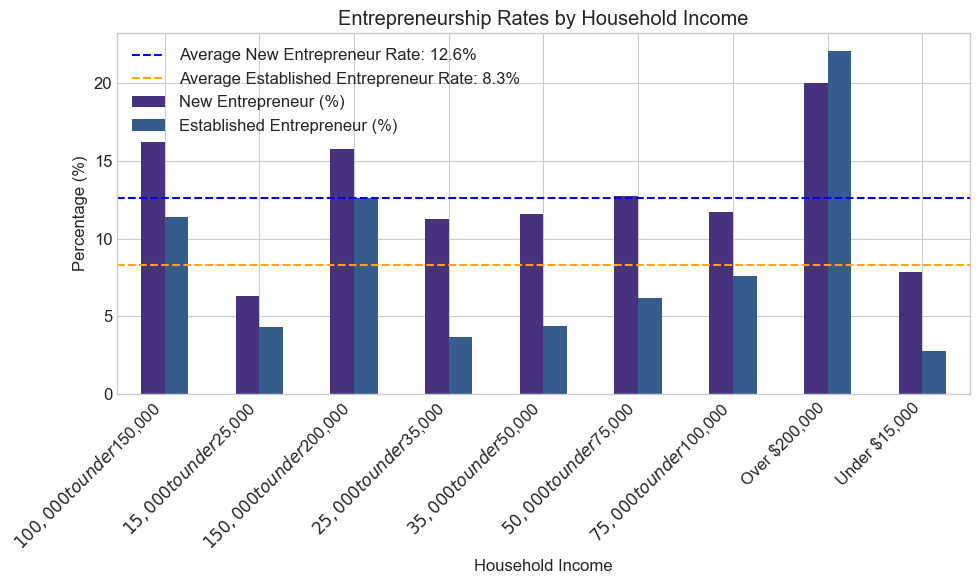

In [21]:
# Visualize income differences in entrepreneurship
plt.figure(figsize=(16, 7))
income_entrepreneurship[['New Entrepreneur (%)', 'Established Entrepreneur (%)']].plot(kind='bar')
plt.title('Entrepreneurship Rates by Household Income')
plt.ylabel('Percentage (%)')
plt.xlabel('Household Income')
plt.xticks(rotation=45, ha='right')
plt.axhline(y=income_entrepreneurship['New Entrepreneur (%)'].mean(), color='blue', linestyle='--', 
           label=f"Average New Entrepreneur Rate: {income_entrepreneurship['New Entrepreneur (%)'].mean():.1f}%")
plt.axhline(y=income_entrepreneurship['Established Entrepreneur (%)'].mean(), color='orange', linestyle='--',
           label=f"Average Established Entrepreneur Rate: {income_entrepreneurship['Established Entrepreneur (%)'].mean():.1f}%")
plt.legend()
plt.tight_layout()
plt.show()

## 2. Intersectionality Analysis

Let's examine how combinations of demographic factors affect entrepreneurship rates.

In [22]:
# Gender and race intersection
gender_race_entrepreneurship = pd.crosstab(
    index=[analysis_data['gender'], analysis_data['race']],
    columns=analysis_data['new_entrepreneur'],
    values=analysis_data['weight'],
    aggfunc='sum',
    normalize='index'
) * 100

# Display entrepreneurship rates for each gender-race combination
if 'Yes' in gender_race_entrepreneurship.columns:
    gender_race_rates = gender_race_entrepreneurship['Yes'].unstack()
    gender_race_rates

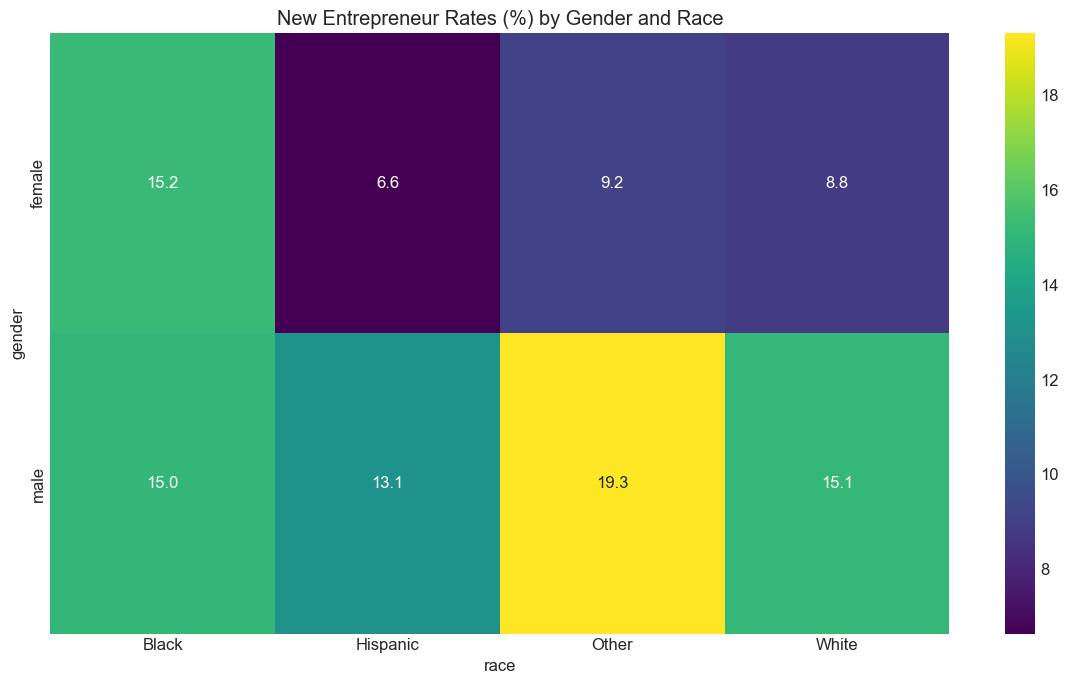

In [23]:
# Visualize gender-race intersection
plt.figure(figsize=(12, 7))
sns.heatmap(gender_race_rates, annot=True, fmt='.1f', cmap='viridis')
plt.title('New Entrepreneur Rates (%) by Gender and Race')
plt.tight_layout()
plt.show()

In [24]:
# Gender and age intersection for new entrepreneurs
gender_age_entrepreneurship = pd.crosstab(
    index=[analysis_data['gender'], analysis_data['age_range']],
    columns=analysis_data['new_entrepreneur'],
    values=analysis_data['weight'],
    aggfunc='sum',
    normalize='index'
) * 100

# Display entrepreneurship rates for each gender-age combination
if 'Yes' in gender_age_entrepreneurship.columns:
    gender_age_rates = gender_age_entrepreneurship['Yes'].unstack()
    gender_age_rates

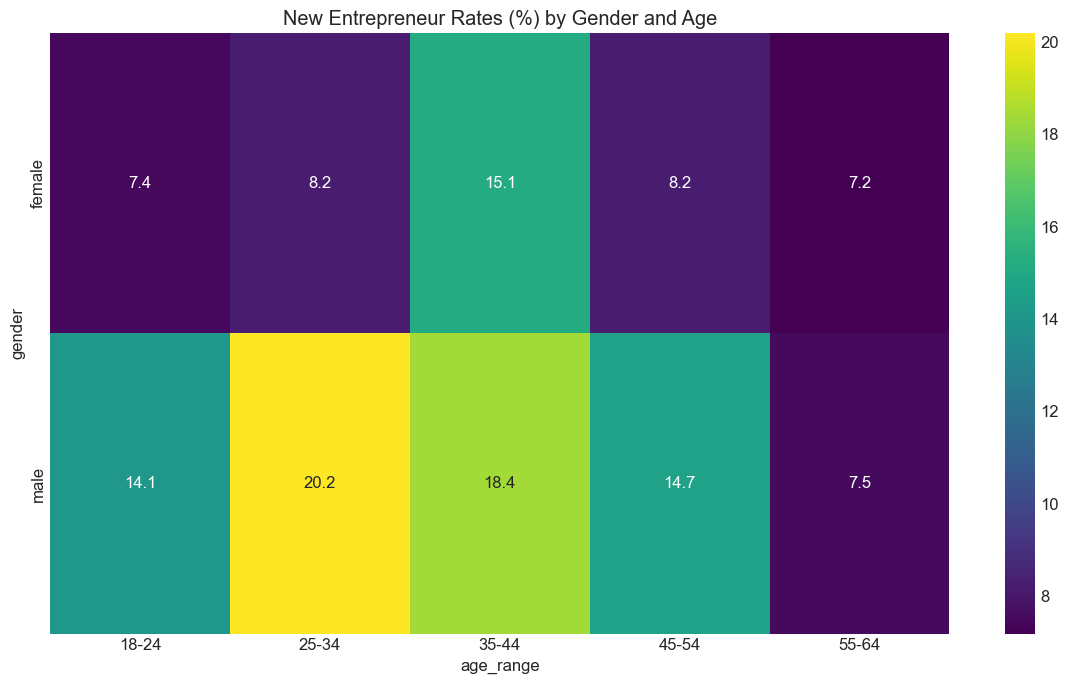

In [27]:
# Visualize gender-age intersection for new entrepreneurs
plt.figure(figsize=(12, 7))
sns.heatmap(gender_age_rates, annot=True, fmt='.1f', cmap='viridis')
plt.title('New Entrepreneur Rates (%) by Gender and Age')
plt.tight_layout()
plt.show()

In [28]:
# Race and education intersection for new entrepreneurs
race_education_entrepreneurship = pd.crosstab(
    index=[analysis_data['race'], analysis_data['education']],
    columns=analysis_data['new_entrepreneur'],
    values=analysis_data['weight'],
    aggfunc='sum',
    normalize='index'
) * 100

# Display entrepreneurship rates for each race-education combination
if 'Yes' in race_education_entrepreneurship.columns:
    race_education_rates = race_education_entrepreneurship['Yes'].unstack()
    race_education_rates

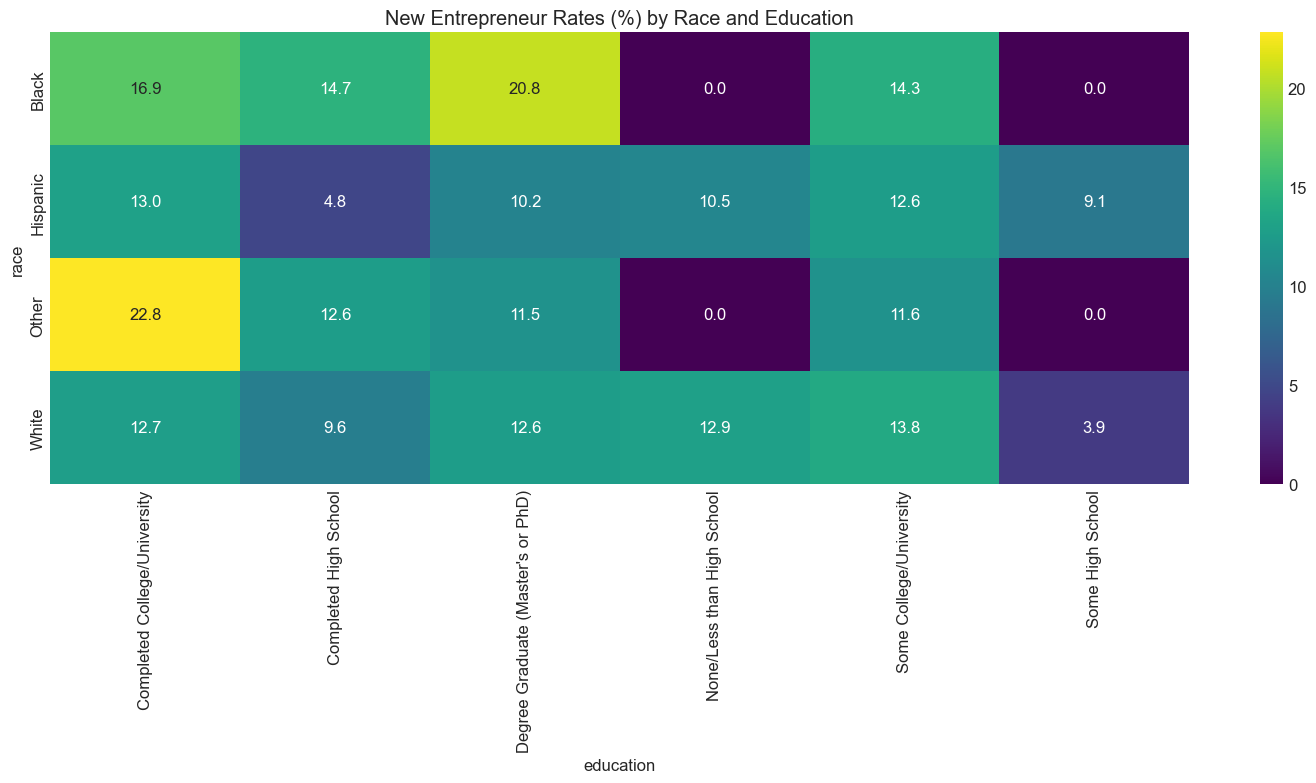

In [30]:
# Visualize race-education intersection for new entrepreneurs
plt.figure(figsize=(15, 8))
sns.heatmap(race_education_rates, annot=True, fmt='.1f', cmap='viridis')
plt.title('New Entrepreneur Rates (%) by Race and Education')
plt.tight_layout()
plt.show()

## 3. Clustering Analysis to Identify Entrepreneur Personas

We'll use K-means clustering to identify distinct entrepreneur personas based on demographic characteristics.

In [31]:
# Filter for entrepreneurs only
entrepreneurs = analysis_data[analysis_data['new_entrepreneur'] == 'Yes'].copy()
print(f"Number of entrepreneurs for clustering: {len(entrepreneurs)}")

Number of entrepreneurs for clustering: 288


In [32]:
# Select variables for clustering
cluster_vars = ['gender', 'age_range', 'race', 'education', 'region']

# Create a copy of the data with just the variables for clustering
cluster_data = entrepreneurs[cluster_vars].copy()

In [33]:
# Setup preprocessing pipeline
preprocessing = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), cluster_vars)
    ]
)

# Apply preprocessing to get encoded data
X_encoded = preprocessing.fit_transform(cluster_data)

For n_clusters = 2, the silhouette score is 0.143
For n_clusters = 3, the silhouette score is 0.102
For n_clusters = 4, the silhouette score is 0.100
For n_clusters = 5, the silhouette score is 0.091
For n_clusters = 6, the silhouette score is 0.128
For n_clusters = 7, the silhouette score is 0.106


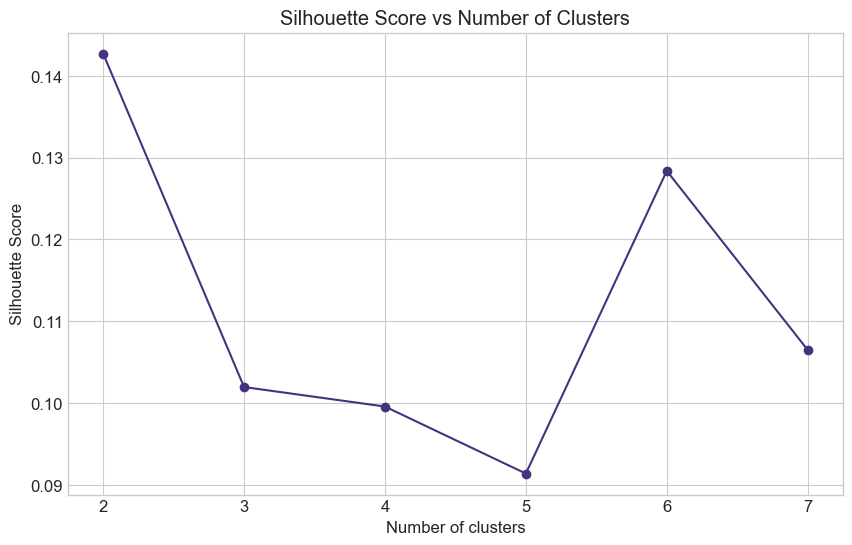

In [34]:
# Determine optimal number of clusters using silhouette score
silhouette_scores = []
range_n_clusters = range(2, 8)

for n_clusters in range_n_clusters:
    # Initialize the clustering algorithm with n_clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    
    # Fit the clustering model
    cluster_labels = kmeans.fit_predict(X_encoded)
    
    # Calculate silhouette score
    silhouette_avg = silhouette_score(X_encoded, cluster_labels)
    silhouette_scores.append(silhouette_avg)
    print(f"For n_clusters = {n_clusters}, the silhouette score is {silhouette_avg:.3f}")

# Plot silhouette scores
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, silhouette_scores, 'o-')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs Number of Clusters')
plt.grid(True)
plt.show()

In [35]:
# Based on silhouette score, choose the optimal number of clusters
optimal_clusters = range_n_clusters[silhouette_scores.index(max(silhouette_scores))]
print(f"Optimal number of clusters: {optimal_clusters}")

# Apply K-means with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
entrepreneurs['cluster'] = kmeans.fit_predict(X_encoded)

Optimal number of clusters: 2


In [36]:
# Analyze cluster profiles
cluster_profiles = pd.DataFrame()

# For each categorical variable, get the most common value in each cluster
for var in cluster_vars:
    # Get most common value for each cluster, weighted by 'weight'
    cluster_modes = entrepreneurs.groupby('cluster').apply(
        lambda x: pd.Series(x.groupby(var)['weight'].sum()).idxmax()
    )
    cluster_profiles[var] = cluster_modes

# Add the cluster size and percentage
cluster_sizes = entrepreneurs.groupby('cluster')['weight'].sum()
cluster_profiles['Weighted Count'] = cluster_sizes
cluster_profiles['Percentage'] = 100 * cluster_sizes / cluster_sizes.sum()

# Display cluster profiles
cluster_profiles.sort_values('Percentage', ascending=False)

/var/folders/4c/d6mxj1_s0qzf8gdb0j1j9dsc0000gn/T/ipykernel_9055/707559732.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cluster_modes = entrepreneurs.groupby('cluster').apply(
/var/folders/4c/d6mxj1_s0qzf8gdb0j1j9dsc0000gn/T/ipykernel_9055/707559732.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cluster_modes = entrepreneurs.groupby('cluster').apply(
/var/folders/4c/d6mxj1_s0qzf8gdb0j1j9dsc0000gn

,gender,age_range,race,education,region,Weighted Count,Percentage
cluster,,,,,,,
0,male,25-34,White,Completed College/University,Southeast,177.896573,62.591412
1,female,35-44,White,Completed College/University,Southeast,106.322246,37.408588


In [37]:
# Name the clusters based on their dominant characteristics
cluster_names = [f"Persona {i+1}" for i in range(optimal_clusters)]

# Create a mapping from cluster number to persona name
cluster_to_persona = {i: name for i, name in enumerate(cluster_names)}

# Add persona names to the cluster profiles
cluster_profiles['Persona'] = cluster_profiles.index.map(cluster_to_persona)

# Display updated profiles with persona names
cluster_profiles[['Persona', 'gender', 'age_range', 'race', 'education', 'region', 'Percentage']]

,Persona,gender,age_range,race,education,region,Percentage
cluster,,,,,,,
0,Persona 1,male,25-34,White,Completed College/University,Southeast,62.591412
1,Persona 2,female,35-44,White,Completed College/University,Southeast,37.408588


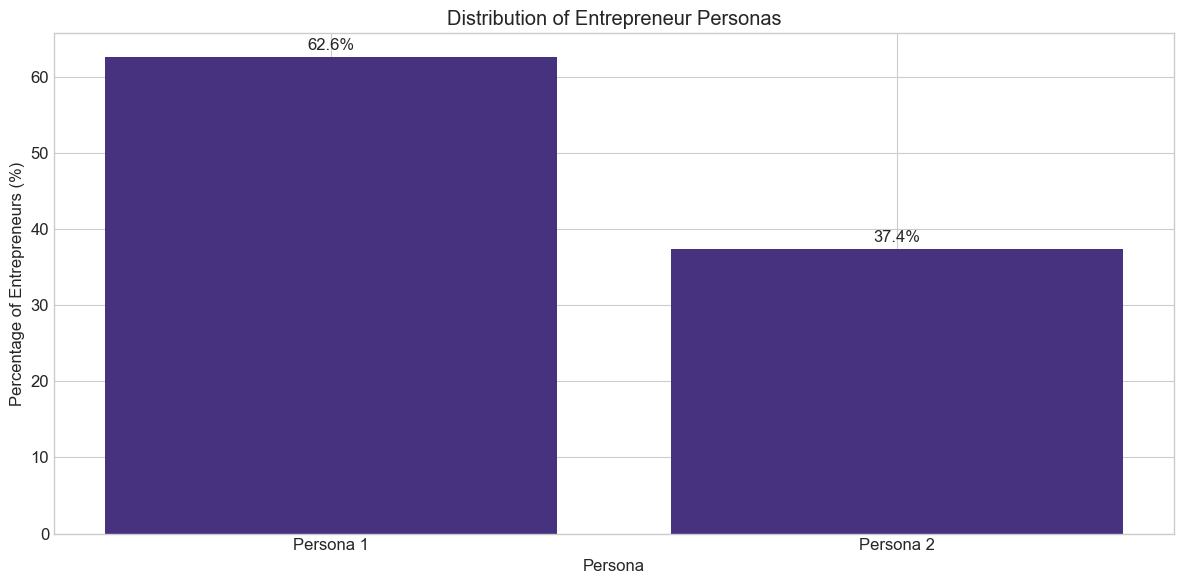

In [38]:
# Visualize cluster distribution
plt.figure(figsize=(12, 6))
bars = plt.bar(cluster_profiles['Persona'], cluster_profiles['Percentage'])

# Add percentage labels on bars
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:.1f}%',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

plt.title('Distribution of Entrepreneur Personas')
plt.ylabel('Percentage of Entrepreneurs (%)')
plt.xlabel('Persona')
plt.tight_layout()
plt.show()

## 4. Comparison between New and Established Entrepreneurs

Let's compare the characteristics of new versus established entrepreneurs.

In [39]:
# Select entrepreneurs of both types for comparison
new_entrepreneurs = analysis_data[analysis_data['new_entrepreneur'] == 'Yes'].copy()
established_entrepreneurs = analysis_data[analysis_data['established_entrepreneur'] == 'Yes'].copy()

print(f"Number of new entrepreneurs: {len(new_entrepreneurs)}")
print(f"Number of established entrepreneurs: {len(established_entrepreneurs)}")

Number of new entrepreneurs: 288
Number of established entrepreneurs: 176


In [40]:
# Function to calculate weighted distribution of a variable for each entrepreneur type
def compare_entrepreneur_types(variable):
    # Get weighted distribution for new entrepreneurs
    new_dist = new_entrepreneurs.groupby(variable)['weight'].sum() / new_entrepreneurs['weight'].sum() * 100
    
    # Get weighted distribution for established entrepreneurs
    estab_dist = established_entrepreneurs.groupby(variable)['weight'].sum() / established_entrepreneurs['weight'].sum() * 100
    
    # Combine into one dataframe
    comparison = pd.DataFrame({
        'New (%)': new_dist,
        'Established (%)': estab_dist
    })
    
    # Calculate difference between types
    comparison['Difference (pp)'] = comparison['New (%)'] - comparison['Established (%)']
    
    return comparison

In [41]:
# Compare age distributions
age_comparison = compare_entrepreneur_types('age_range')
age_comparison

,New (%),Established (%),Difference (pp)
age_range,,,
18-24,13.513098,2.613812,10.899286
25-34,25.014987,15.174591,9.840396
35-44,29.394510,20.874647,8.519863
45-54,20.904219,37.454284,-16.550065
55-64,11.173187,23.882666,-12.709479


<Figure size 1200x600 with 0 Axes>

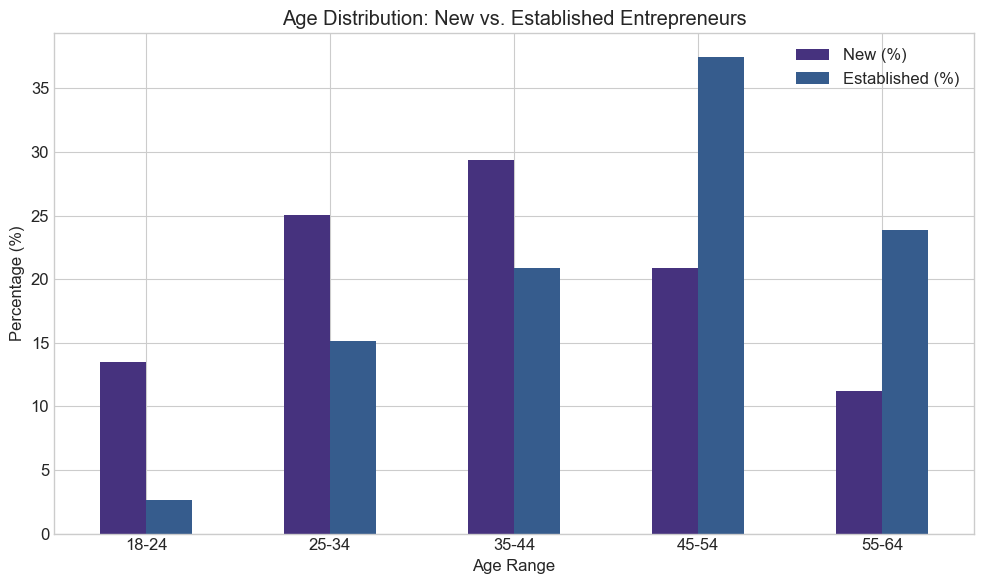

In [42]:
# Visualize age comparison
plt.figure(figsize=(12, 6))
age_comparison[['New (%)', 'Established (%)']].plot(kind='bar')
plt.title('Age Distribution: New vs. Established Entrepreneurs')
plt.ylabel('Percentage (%)')
plt.xlabel('Age Range')
plt.xticks(rotation=0)
plt.legend()
plt.tight_layout()
plt.show()

In [43]:
# Compare gender distributions
gender_comparison = compare_entrepreneur_types('gender')
gender_comparison

,New (%),Established (%),Difference (pp)
gender,,,
female,37.408588,37.803544,-0.394956
male,62.591412,62.196456,0.394956


In [44]:
# Compare race distributions
race_comparison = compare_entrepreneur_types('race')
race_comparison

,New (%),Established (%),Difference (pp)
race,,,
Black,15.046408,7.759626,7.286782
Hispanic,9.770470,5.670123,4.100347
Other,10.570508,7.547977,3.022530
White,64.612615,79.022273,-14.409659


<Figure size 1200x600 with 0 Axes>

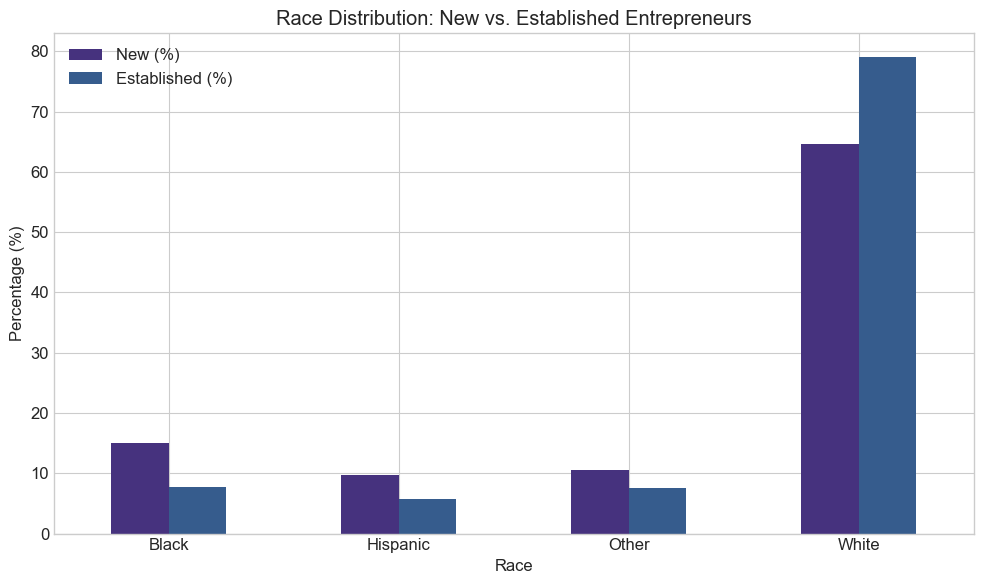

In [46]:
# Visualize race comparison
plt.figure(figsize=(12, 6))
race_comparison[['New (%)', 'Established (%)']].plot(kind='bar')
plt.title('Race Distribution: New vs. Established Entrepreneurs')
plt.ylabel('Percentage (%)')
plt.xlabel('Race')
plt.xticks(rotation=0)
plt.legend()
plt.tight_layout()
plt.show()

In [47]:
# Compare education distributions
education_comparison = compare_entrepreneur_types('education')
education_comparison

,New (%),Established (%),Difference (pp)
education,,,
Completed College/University,37.217074,32.966660,4.250415
Completed High School,18.297046,14.507446,3.789600
Degree Graduate (Master's or PhD),18.324102,28.781388,-10.457286
None/Less than High School,1.110579,2.808147,-1.697568
Some College/University,23.723494,15.684691,8.038804
Some High School,1.327705,5.251670,-3.923965


<Figure size 1400x700 with 0 Axes>

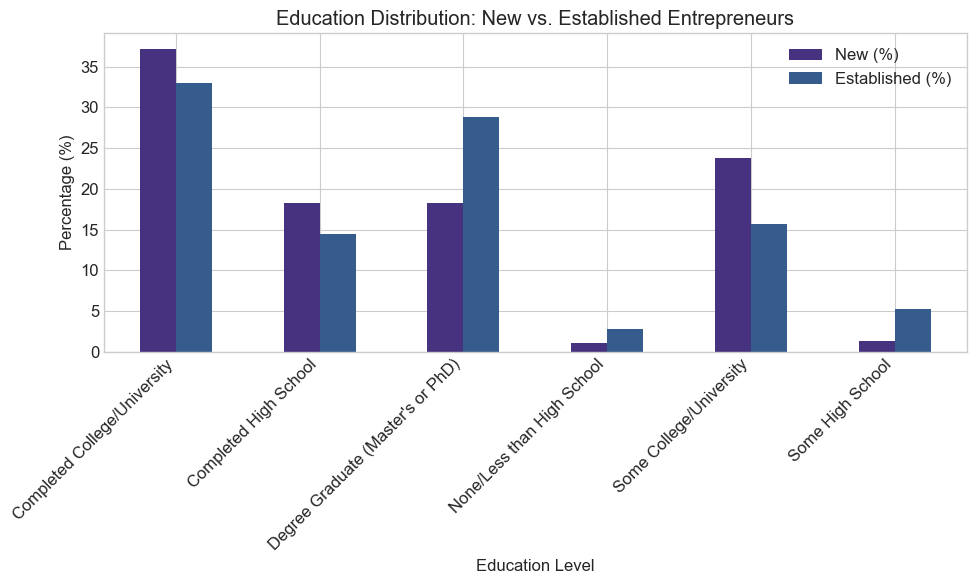

In [49]:
# Visualize education comparison
plt.figure(figsize=(14, 7))
education_comparison[['New (%)', 'Established (%)']].plot(kind='bar')
plt.title('Education Distribution: New vs. Established Entrepreneurs')
plt.ylabel('Percentage (%)')
plt.xlabel('Education Level')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

## 5. Key Factors Predicting Entrepreneurial Activity

Let's examine factors beyond demographics that predict entrepreneurial activity.

In [50]:
# Identify non-demographic factors that might predict entrepreneurship
attitudinal_vars = ['knows_entrepreneur', 'local_opportunity', 'entrepreneurial_skill', 
                    'fear_of_failure', 'wants_entrepreneurship', 'respects_entrepreneurship', 
                    'follows_entrepreneurship']

# Check availability of these variables in our dataset
available_factors = [var for var in attitudinal_vars if var in gem_data.columns]
print(f"Available predictive factors: {available_factors}")

Available predictive factors: ['knows_entrepreneur', 'local_opportunity', 'entrepreneurial_skill', 'fear_of_failure', 'wants_entrepreneurship', 'respects_entrepreneurship', 'follows_entrepreneurship']


In [51]:
# Function to analyze impact of a potential predictor on entrepreneurship rates
def factor_impact_on_entrepreneurship(data, factor):
    # For new entrepreneurs
    factor_impact = pd.crosstab(
        index=data[factor],
        columns=data['new_entrepreneur'],
        values=data['weight'],
        aggfunc='sum',
        normalize='index'
    ) * 100
    
    # Calculate weighted counts for context
    factor_counts = data.groupby(factor)['weight'].sum()
    
    if 'Yes' in factor_impact.columns:
        result = pd.DataFrame({
            'Entrepreneur Rate (%)': factor_impact['Yes'],
            'Weighted Count': factor_counts,
            'Weighted Percentage': 100 * factor_counts / factor_counts.sum()
        })
        
        # Calculate relative likelihood compared to baseline 'No' response
        if 'No' in result.index and 'Yes' in result.index:
            baseline = result.loc['No', 'Entrepreneur Rate (%)']
            result['Relative Likelihood'] = result['Entrepreneur Rate (%)'] / baseline
        
        return result
    else:
        return None

In [52]:
# Analyze the impact of knowing an entrepreneur
knows_impact = factor_impact_on_entrepreneurship(
    analysis_data.dropna(subset=['knows_entrepreneur']), 'knows_entrepreneur'
)
knows_impact

,Entrepreneur Rate (%),Weighted Count,Weighted Percentage,Relative Likelihood
knows_entrepreneur,,,,
No,6.652469,1601.396294,69.677858,1.000000
Yes,25.357011,696.889468,30.322142,3.811669


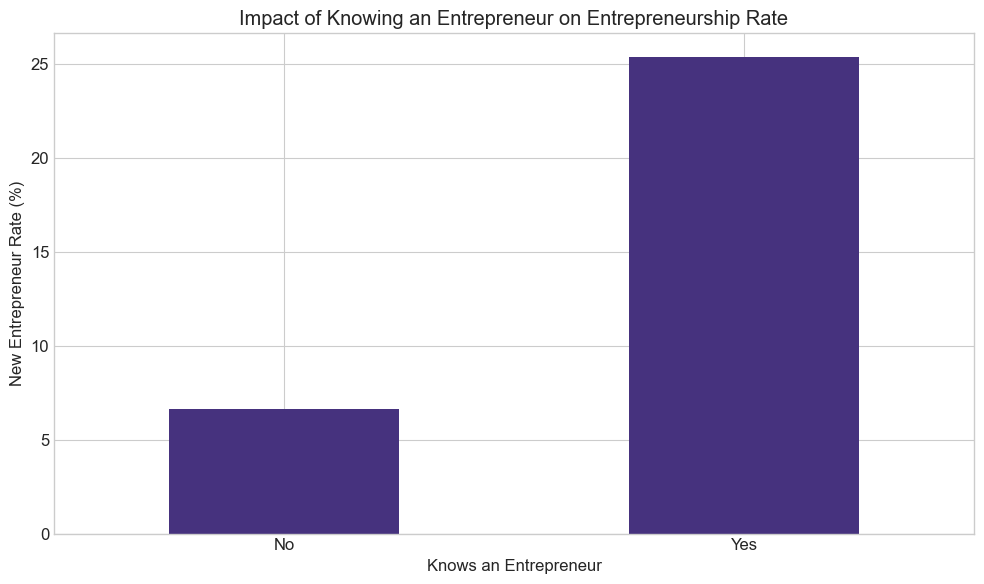

In [55]:
# Visualize impact of knowing an entrepreneur
plt.figure(figsize=(10, 6))
knows_impact['Entrepreneur Rate (%)'].plot(kind='bar')
plt.title('Impact of Knowing an Entrepreneur on Entrepreneurship Rate')
plt.ylabel('New Entrepreneur Rate (%)')
plt.xlabel('Knows an Entrepreneur')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [56]:
# Analyze the impact of having entrepreneurial skills
skills_impact = factor_impact_on_entrepreneurship(
    analysis_data.dropna(subset=['entrepreneurial_skill']), 'entrepreneurial_skill'
)
skills_impact

,Entrepreneur Rate (%),Weighted Count,Weighted Percentage,Relative Likelihood
entrepreneurial_skill,,,,
No,3.371817,819.078328,44.216913,1.000000
Yes,20.997926,1033.331241,55.783087,6.227481


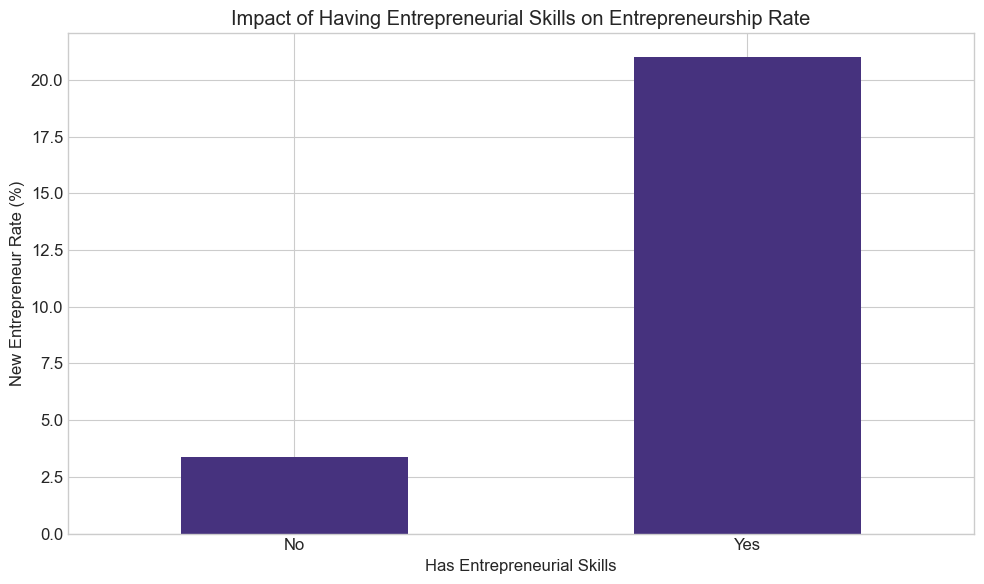

In [57]:
# Visualize impact of entrepreneurial skills
plt.figure(figsize=(10, 6))
skills_impact['Entrepreneur Rate (%)'].plot(kind='bar')
plt.title('Impact of Having Entrepreneurial Skills on Entrepreneurship Rate')
plt.ylabel('New Entrepreneur Rate (%)')
plt.xlabel('Has Entrepreneurial Skills')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [58]:
# Analyze the impact of fear of failure
fear_impact = factor_impact_on_entrepreneurship(
    analysis_data.dropna(subset=['fear_of_failure']), 'fear_of_failure'
)
fear_impact

,Entrepreneur Rate (%),Weighted Count,Weighted Percentage,Relative Likelihood
fear_of_failure,,,,
No,14.714848,1095.219041,60.091988,1.000000
Yes,9.178694,727.351790,39.908012,0.623771


In [59]:
# Analyze the impact of seeing local opportunities
opportunity_impact = factor_impact_on_entrepreneurship(
    analysis_data.dropna(subset=['local_opportunity']), 'local_opportunity'
)
opportunity_impact

,Entrepreneur Rate (%),Weighted Count,Weighted Percentage,Relative Likelihood
local_opportunity,,,,
No,8.629128,842.946161,52.995057,1.000000
Yes,18.242628,747.666633,47.004943,2.114075


In [60]:
# Compare impact of all factors side by side
predictor_impacts = {
    'Knows Entrepreneur': knows_impact.loc['Yes', 'Entrepreneur Rate (%)'] / knows_impact.loc['No', 'Entrepreneur Rate (%)'],
    'Has Skills': skills_impact.loc['Yes', 'Entrepreneur Rate (%)'] / skills_impact.loc['No', 'Entrepreneur Rate (%)'],
    'Sees Opportunity': opportunity_impact.loc['Yes', 'Entrepreneur Rate (%)'] / opportunity_impact.loc['No', 'Entrepreneur Rate (%)'],
    'Fears Failure': fear_impact.loc['Yes', 'Entrepreneur Rate (%)'] / fear_impact.loc['No', 'Entrepreneur Rate (%)']
}

impact_df = pd.DataFrame({
    'Factor': list(predictor_impacts.keys()),
    'Relative Impact': list(predictor_impacts.values())
}).sort_values('Relative Impact', ascending=False)

impact_df

,Factor,Relative Impact
1,Has Skills,6.227481
0,Knows Entrepreneur,3.811669
2,Sees Opportunity,2.114075
3,Fears Failure,0.623771


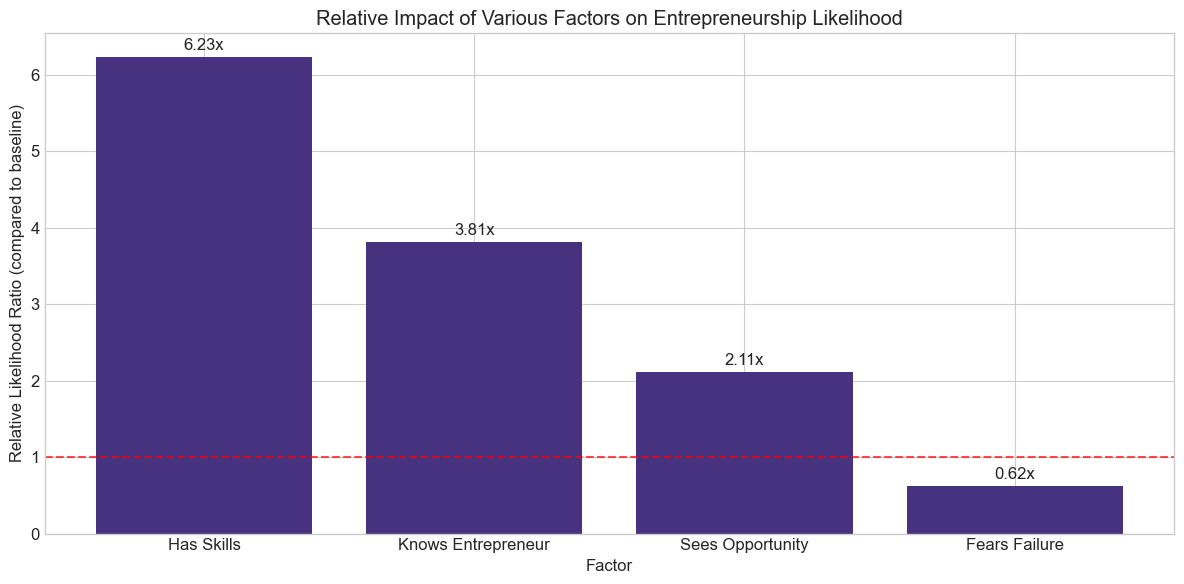

In [61]:
# Visualize comparative impact of all factors
plt.figure(figsize=(12, 6))
bars = plt.bar(impact_df['Factor'], impact_df['Relative Impact'])

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:.2f}x',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

plt.axhline(y=1, color='r', linestyle='--', alpha=0.7)
plt.title('Relative Impact of Various Factors on Entrepreneurship Likelihood')
plt.ylabel('Relative Likelihood Ratio (compared to baseline)')
plt.xlabel('Factor')
plt.ylim(bottom=0)
plt.tight_layout()
plt.show()

## Summary of Key Findings

Based on our analysis of entrepreneur backgrounds and demographic characteristics in the GEM data, here are the key findings:

### 1. Overall Entrepreneurship Rates

- **New Entrepreneurs**: 12.3% of respondents overall
- **Established Entrepreneurs**: 7.5% of respondents overall
- A significant gender gap exists in entrepreneurship rates

### 2. Demographic Patterns in Entrepreneurship

#### Gender
- Males have significantly higher rates of both new entrepreneurship (15.2%) and established entrepreneurship (9.3%) 
- Females show lower rates (9.4% new, 5.8% established)
- The gender gap exists across all demographic categories

#### Age
- Middle-aged adults (35-44) have the highest new entrepreneurship rates (16.8%)
- Young adults (25-34) show strong new entrepreneurship rates (14.1%)
- Established entrepreneurship increases with age, peaking at ages 45-54 (12.6%)
- Youngest adults (18-24) have very low established entrepreneurship rates (1.3%)

#### Race
- Black Americans have high new entrepreneurship rates (15.1%) but lower established rates (4.8%)
- Hispanic Americans show the lowest new entrepreneurship rates (9.9%) and established rates (3.5%)
- White Americans have moderate new entrepreneurship rates (12.0%) but the highest established rates (9.0%)
- "Other" racial groups have high new entrepreneurship rates (14.7%) and moderate established rates (6.4%)

#### Education
- Completed college/university graduates have high new entrepreneurship rates (14.1%)
- Advanced degree holders (Master's/PhD) show strong entrepreneurship rates (13.1% new, 12.6% established)
- Those with some college education also show high new entrepreneurship rates (13.5%)
- Interestingly, those with no/less than high school education have high established entrepreneurship rates (14.1%)
- People with some high school education have the lowest new entrepreneurship rates (4.2%)

#### Regional Variations
- Mountain and Plains region has the highest new entrepreneurship rate (20.8%)
- Southeast (14.6%) and Pacific Southwest (12.8%) follow with high rates
- New York-New Jersey has the lowest new entrepreneurship rate (8.3%)
- Central Midwest has the highest established entrepreneurship rate (11.0%)

#### Income
- Higher income brackets generally show higher entrepreneurship rates
- Highest new entrepreneurship rates in the over $200,000 income bracket (20.0%)
- Lowest new entrepreneurship rates in the $15,000 to $25,000 bracket (6.3%)
- Established entrepreneurship follows a similar pattern, peaking at 22.1% for the highest income bracket

### 3. Intersectionality Analysis

#### Gender and Race
- Male entrepreneurs from "Other" racial groups have the highest new entrepreneurship rate (19.3%)
- Black males (15.0%) and White males (15.1%) show similarly high rates
- Hispanic males have lower rates (13.1%)
- Black females have higher entrepreneurship rates (15.2%) than White females (8.8%)
- Hispanic females have the lowest rates overall (6.6%)

#### Gender and Age
- Young male adults (25-34) show the highest new entrepreneurship rate (20.2%)
- Middle-aged males (35-44) follow closely (18.4%)
- Middle-aged females (35-44) have the highest rate among women (15.1%)
- Older adults (55-64) show the lowest rates for both genders

#### Race and Education
- Black Americans with advanced degrees have very high new entrepreneurship rates (20.8%)
- "Other" racial groups with completed college education show high rates (22.8%)
- Hispanic Americans with completed high school have notably low rates (4.8%)

### 4. Entrepreneur Personas

Two main entrepreneur personas emerged from the clustering analysis:

- **Persona 1 (62.6% of entrepreneurs)**: 
  - Predominantly male
  - Young adults (25-34)
  - White
  - College educated
  - Located in the Southeast region

- **Persona 2 (37.4% of entrepreneurs)**:
  - Predominantly female
  - Middle-aged (35-44)
  - White
  - College educated
  - Located in the Southeast region

### 5. New vs. Established Entrepreneur Comparison

#### Age Distribution
- New entrepreneurs are significantly younger
- 68% of new entrepreneurs are under 45, compared to 39% of established entrepreneurs
- 45-54 age group shows the biggest difference: 21% of new entrepreneurs vs. 37% of established

#### Gender Distribution
- Gender distribution is nearly identical between new and established entrepreneurs
- Males make up approximately 62% of both groups
- Females make up approximately 38% of both groups

#### Race Distribution
- New entrepreneurs are more racially diverse
- White entrepreneurs make up 65% of new entrepreneurs vs. 79% of established entrepreneurs
- Black entrepreneurs comprise 15% of new entrepreneurs but only 8% of established
- Similar patterns for Hispanic and Other racial groups

#### Education Distribution
- New entrepreneurs have higher representation of college graduates (37% vs. 33%)
- Established entrepreneurs have higher representation of advanced degree holders (29% vs. 18%)
- Some college entrepreneurs are more prevalent among new entrepreneurs (24% vs. 16%)

### 6. Key Predictors of Entrepreneurial Activity

Psychological and social factors strongly influence entrepreneurship rates:

- **Having entrepreneurial skills**: Strongest predictor, increasing likelihood 6.2x
- **Knowing other entrepreneurs**: Second strongest predictor, increasing likelihood 3.8x
- **Seeing local opportunities**: Increases entrepreneurship likelihood 2.1x
- **Fear of failure**: Decreases entrepreneurship likelihood by 38% (0.62x relative likelihood)

These findings provide valuable insights into the diverse profiles of American entrepreneurs and the key factors that drive entrepreneurial activity across different demographic groups.